In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Load Dataset
df = pd.read_csv('Training Dataset/final_dataset.csv', encoding='utf-8-sig')
df = df[df.columns[-2:]]  # Only get sentence and labels

In [4]:
# Get Sentences data from data frame
sentences = df['Sentence'].values
labels = df['Label'].values


In [5]:
# Ensure sentences are strings and handle NaN or non-string values
sentences = df['Sentence'].fillna('').astype(str).values

# Convert to ASCII
def convert_to_ascii(sentence):
    sentence_ascii = []
    for char in sentence:
        if ord(char) < 8222:
            if ord(char) == 8217:  # ’
                sentence_ascii.append(134)
            elif ord(char) == 8221:  # ”
                sentence_ascii.append(129)
            elif ord(char) == 8220:  # “
                sentence_ascii.append(130)
            elif ord(char) == 8216:  # ‘
                sentence_ascii.append(131)
            elif ord(char) == 8211:  # –
                sentence_ascii.append(133)
            if ord(char) <= 128:
                sentence_ascii.append(ord(char))
    zer = np.zeros((10000,))
    for i in range(len(sentence_ascii)):
        zer[i] = sentence_ascii[i]
    zer.shape = (100, 100)
    return zer


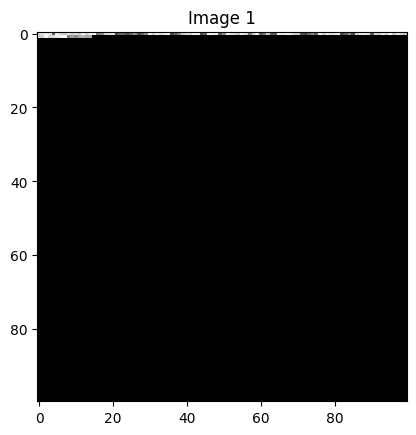

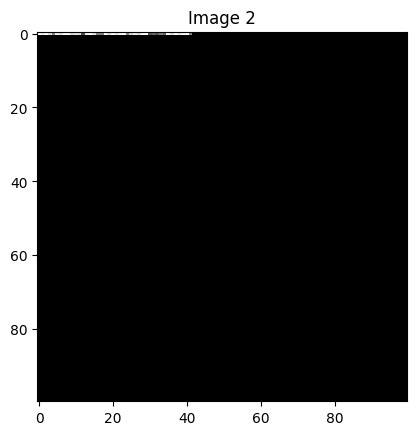

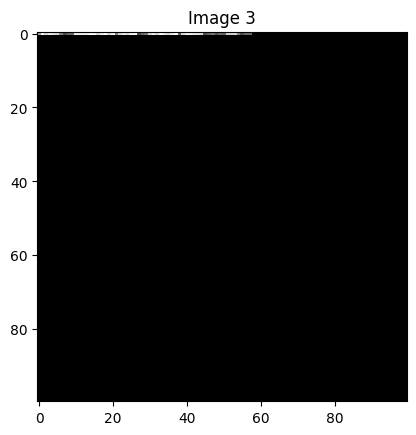

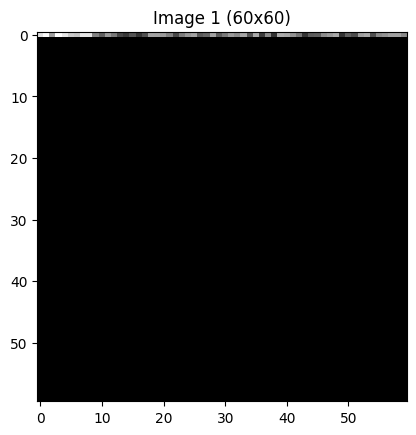

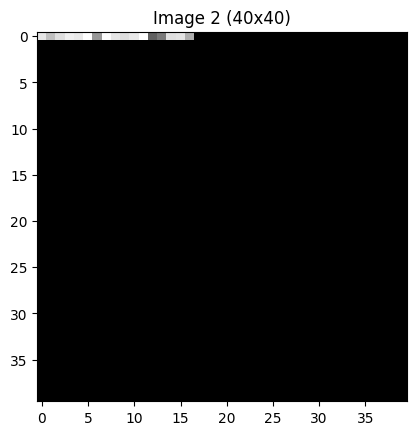

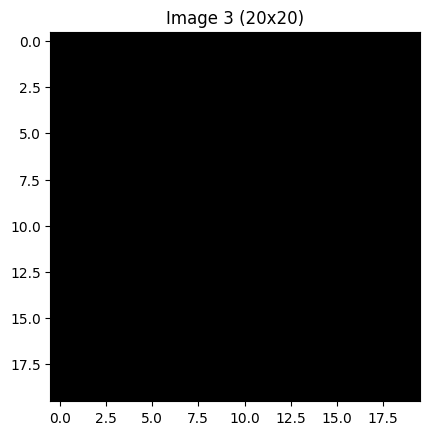

In [6]:
# Prepare Data
arr = np.zeros((len(sentences), 100, 100))
for i in range(len(sentences)):
    image = convert_to_ascii(sentences[i])
    x = np.asarray(image, dtype='float')
    image = cv2.resize(x, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    image /= 128
    arr[i] = image

# Show the first two images in the data array
for i in range(3):
    plt.imshow(arr[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.show()

# Show the first three images with different sizes
for i in range(3):
    # Resize images to the specified sizes
    if i == 0:
        resized_image = cv2.resize(arr[i], dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
    elif i == 1:
        resized_image = cv2.resize(arr[i], dsize=(40, 40), interpolation=cv2.INTER_CUBIC)
    else:
        resized_image = cv2.resize(arr[i], dsize=(20, 20), interpolation=cv2.INTER_CUBIC)

    plt.imshow(resized_image, cmap='gray')
    plt.title(f'Image {i + 1} ({resized_image.shape[1]}x{resized_image.shape[0]})')
    plt.show()

In [7]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 1, 100, 100)

In [8]:
# Create PyTorch Dataset
class XSSDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [9]:
# Split data: train 70%, verify 20%, test 10%
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.3, random_state=42)
verify_data, test_data, verify_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=1/3, random_state=42)

train_dataset = XSSDataset(train_data, train_labels)
verify_dataset = XSSDataset(verify_data, verify_labels)
test_dataset = XSSDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
verify_loader = DataLoader(verify_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


In [11]:
# Train and test with different learning rates
learning_rates = [0.001, 0.002, 0.01, 0.02, 0.05]
num_epochs = 20
all_loss_train = []
all_loss_verify = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = CNNModel()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_train = []
    loss_verify = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_train.append(epoch_loss / len(train_loader))

        # Validation loss
        model.eval()
        verify_loss = 0
        with torch.no_grad():
            for inputs, labels in verify_loader:
                outputs = model(inputs.float())
                loss = criterion(outputs.squeeze(), labels.float())
                verify_loss += loss.item()
        loss_verify.append(verify_loss / len(verify_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_train[-1]:.4f}, Verify Loss: {loss_verify[-1]:.4f}")

    all_loss_train.append(loss_train)
    all_loss_verify.append(loss_verify)



Training with learning rate: 0.001
Epoch [1/20], Training Loss: 0.3116, Verify Loss: 0.1514


In [ ]:
# Plot training and verify loss for each learning rate
for i, lr in enumerate(learning_rates):
    plt.plot(all_loss_train[i], label=f'Train Loss (lr={lr})')
    plt.plot(all_loss_verify[i], label=f'Verify Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curves for learning rate = {lr}')
    plt.show()

In [ ]:
# Prediction on test data
model.eval()
predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.float())
        predictions.extend(outputs.squeeze().round().numpy())

Epoch [1/4], Loss: 0.4470
Epoch [2/4], Loss: 0.0826
Epoch [3/4], Loss: 0.0829
Epoch [4/4], Loss: 0.0243


In [ ]:
# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
confusion = confusion_matrix(test_labels, predictions)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix: \n", confusion)

Accuracy:  0.9726077428780131
Precision:  0.9636483807005949
Recall:  0.986468200270636
Confusion Matrix: 
 [[1205   55]
 [  20 1458]]
